<a href="https://colab.research.google.com/github/itailironne/ML-course-final-thesis/blob/master/Prepay_Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    Table of Contents:
    1. Data Generation
    2. Feature Engineering
    3. Outlier Detection and Removal
    4. Feature Engineering Explanations
    5. Data Balancing
    6. Exploratory Data Analysis (EDA)
    7. Model Training
    8. Model Evaluation
    9. Feature Importance
    10. Save the Model
    


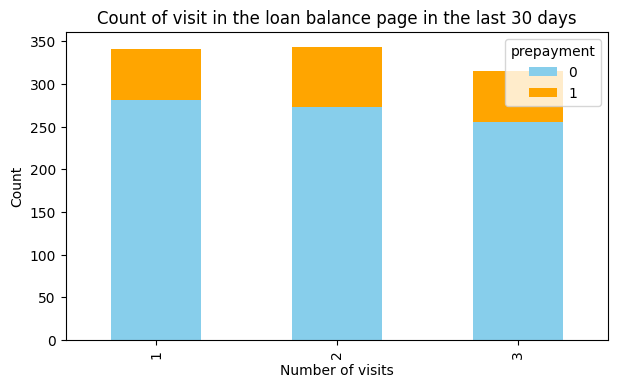

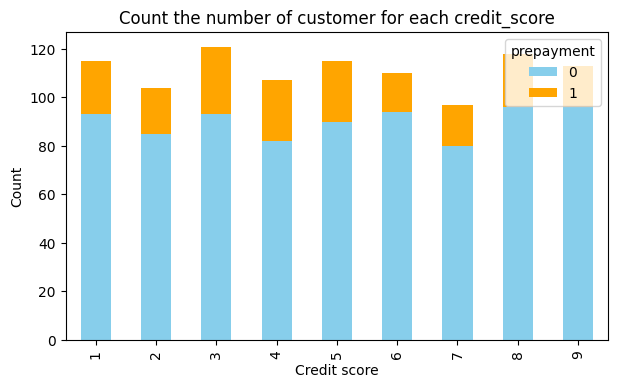

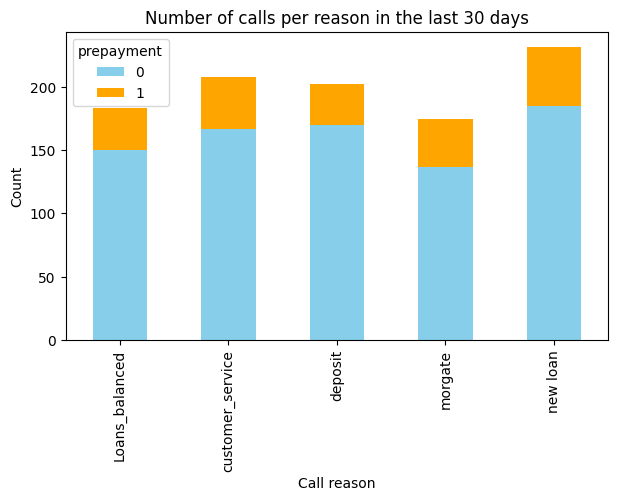

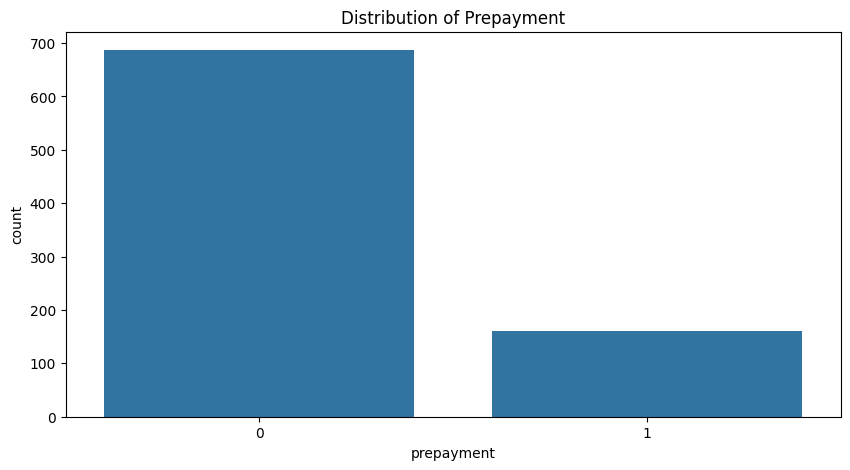

,Feature,Explanation
0,monthly_pay_to_monthly_income,Ratio of monthly loan payment to monthly income.
1,prop_visits_deposit,prop_visits_deposit
2,prop_time_deposit,prop_time_deposit
3,time_surfing_deposit_ratio,Ratio of time spent on the deposit page to tot...
4,total_visit_duration,"Total duration of all visits (deposit, loans, ..."
5,loan_amount_to_income_ratio,Ratio of loan amount to annual income.


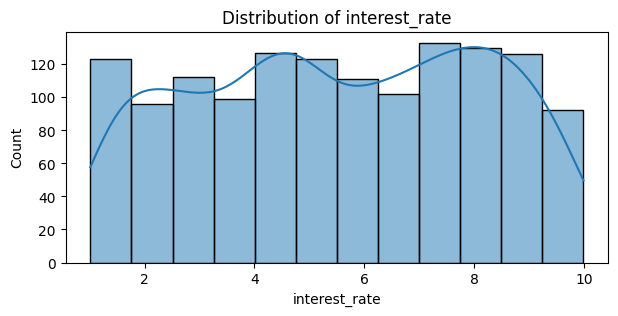

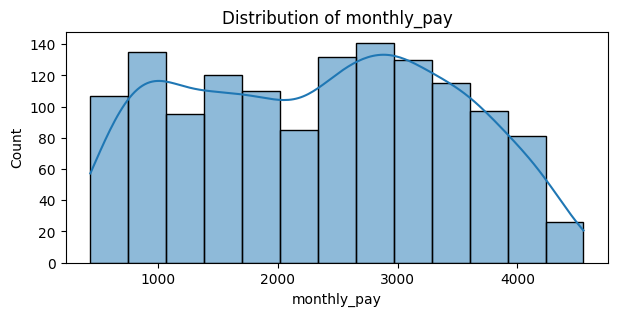

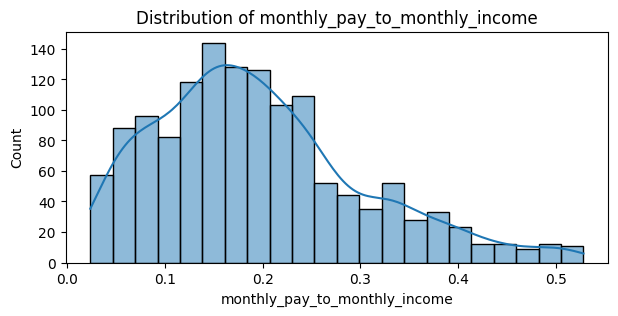

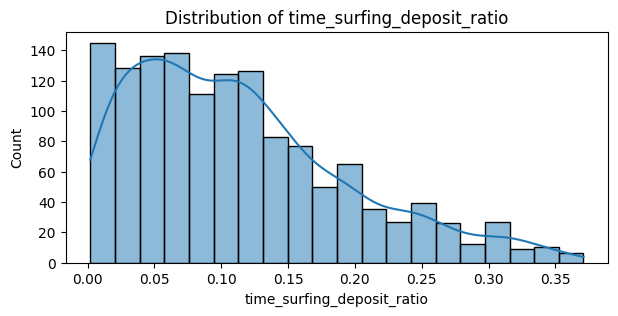

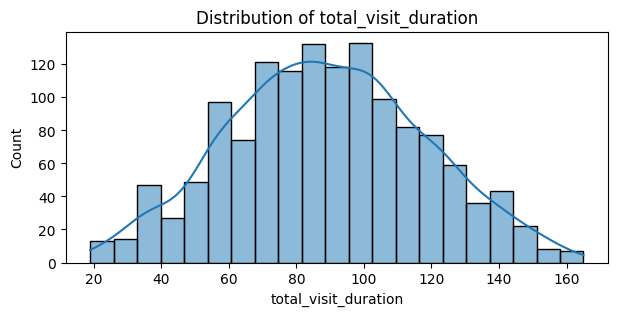

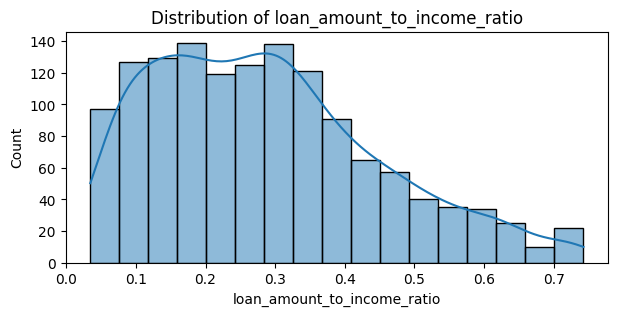

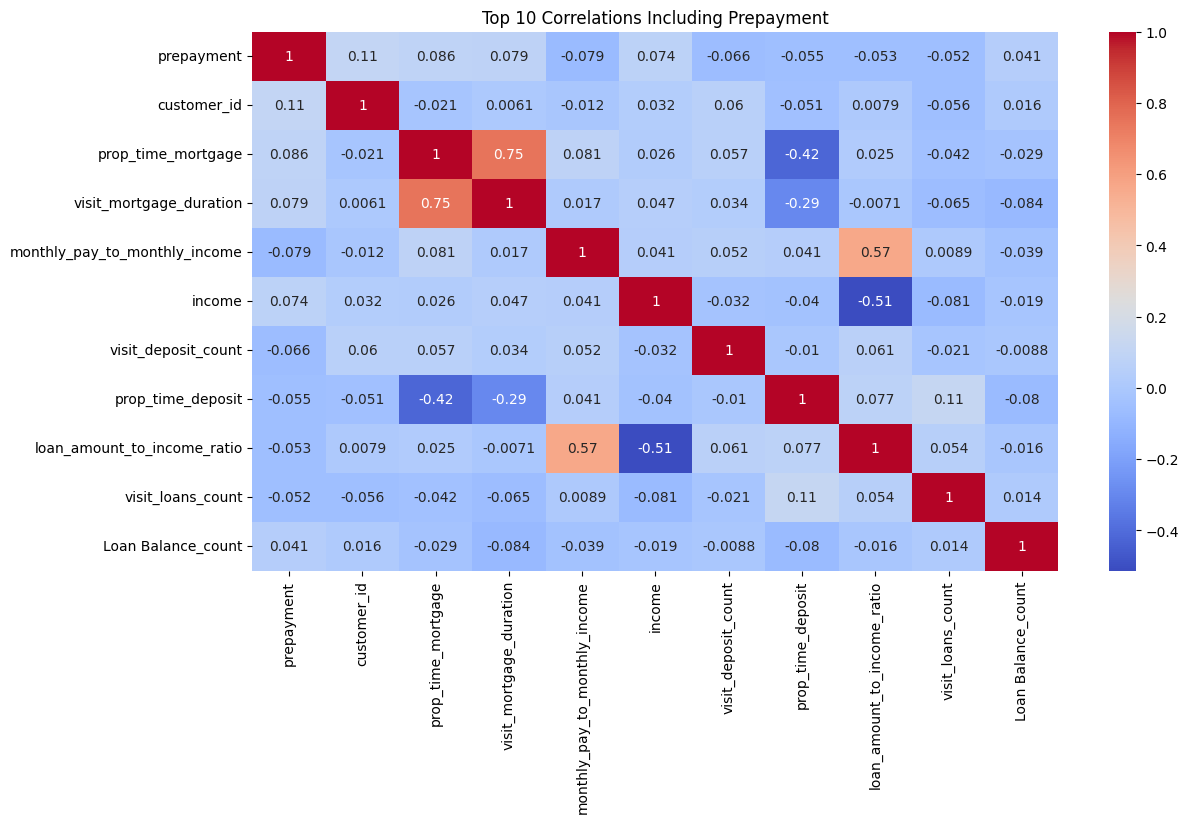

Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       212
           1       0.92      0.97      0.94       201

    accuracy                           0.94       413
   macro avg       0.94      0.94      0.94       413
weighted avg       0.95      0.94      0.94       413



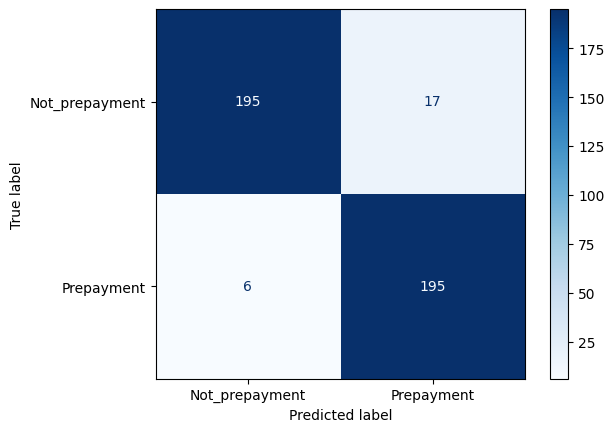

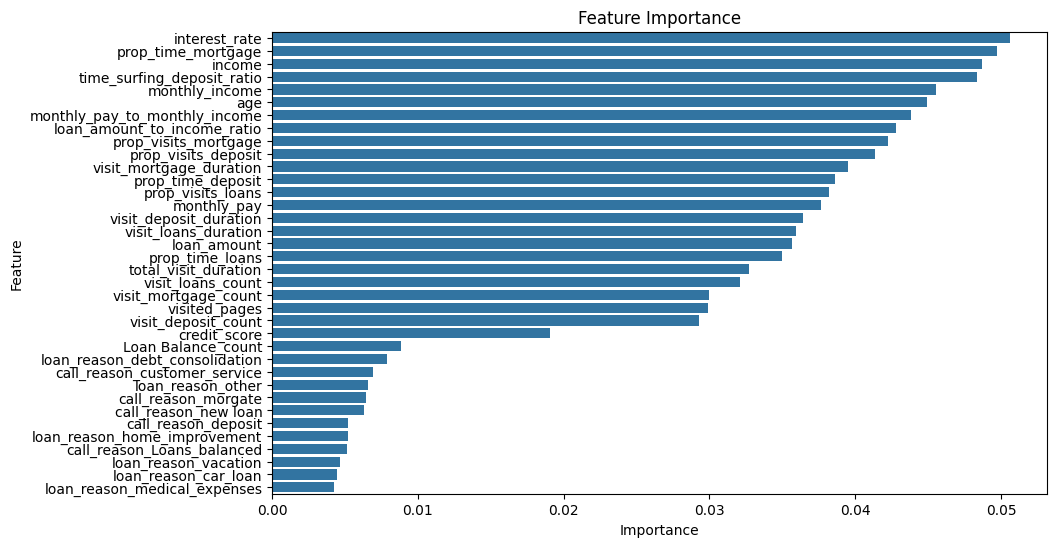

,age,income,loan_amount,credit_score,visited_pages,monthly_income,visit_deposit_count,visit_deposit_duration,visit_loans_duration,visit_loans_count,...,loan_reason_home_improvement,loan_reason_medical_expenses,loan_reason_other,loan_reason_vacation,call_reason_Loans_balanced,call_reason_customer_service,call_reason_deposit,call_reason_morgate,call_reason_new loan,Is_Prepayment
628,34,63919,21052,3,39,10057,12,7,56,6,...,False,False,False,True,False,False,True,False,False,0
858,56,81598,48590,4,46,8253,8,49,3,16,...,True,False,False,False,False,False,True,False,False,0
430,53,85367,11704,2,32,17454,7,4,57,13,...,False,True,False,False,True,False,False,False,False,0
258,23,51645,22772,5,34,14873,15,45,1,10,...,False,False,True,False,False,False,False,False,True,0
358,44,126534,16130,7,16,13874,4,35,57,4,...,False,False,False,False,True,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,45,109720,17504,5,11,13169,16,33,31,1,...,False,False,False,False,False,False,True,False,False,0
637,53,123972,27420,1,13,9362,7,20,19,11,...,True,False,False,False,True,False,False,False,False,1
999,55,118577,10432,8,20,7765,4,42,28,8,...,False,False,False,False,True,False,False,False,False,1
489,29,61046,27641,3,21,6782,14,13,17,5,...,False,False,False,True,False,True,False,False,False,0


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import joblib

# Table of Contents
def print_table_of_contents():
    toc = """
    Table of Contents:
    1. Data Generation
    2. Feature Engineering
    3. Outlier Detection and Removal
    4. Feature Engineering Explanations
    5. Data Balancing
    6. Exploratory Data Analysis (EDA)
    7. Model Training
    8. Model Evaluation
    9. Feature Importance
    10. Save the Model
    """
    print(toc)

print_table_of_contents()

# Set random seed for reproducibility
np.random.seed(42)

# Define number of samples
num_samples = 1000

# Generate synthetic data
loan_reasons = ['debt_consolidation', 'home_improvement', 'car_loan', 'medical_expenses', 'vacation', 'other']

call_reasons = ['Loans_balanced','new loan', 'morgate', 'deposit', 'customer_service']

data = {
    'customer_id': np.arange(1, num_samples + 1),
    'age': np.random.randint(18, 70, num_samples),
    'income': np.random.randint(50000, 150000, num_samples),
    'loan_amount': np.random.randint(5000, 50000, num_samples),
    'credit_score': np.random.randint(1, 10, num_samples),
    'surfing_time': np.random.randint(50, 500, num_samples),
    'visited_pages': np.random.randint(5, 50, num_samples),
     'loan_reason': np.random.choice(loan_reasons, num_samples),
    'call_reason': np.random.choice(call_reasons, num_samples),
    'monthly_income': np.random.randint(5000, 20000, num_samples),
    'visit_deposit_count': np.random.randint(1, 20, num_samples),
    'visit_deposit_duration': np.random.randint(1, 60, num_samples),
     'visit_loans_duration': np.random.randint(1, 60, num_samples),
    'visit_loans_count': np.random.randint(1, 20, num_samples),
    'Loan Balance_count': np.random.randint(1, 4, num_samples),
    'visit_loans_duration': np.random.randint(1, 60, num_samples),
    'visit_mortgage_count': np.random.randint(1, 20, num_samples),
    'visit_mortgage_duration': np.random.randint(1, 60, num_samples),
    'interest_rate': np.random.uniform(1.0, 10.0, num_samples),
    'prepayment': np.random.choice([0, 1], num_samples, p=[0.8, 0.2])  # 80% not prepaid, 20% prepaid
}



# Calculate monthly pay assuming a simple interest model with fixed monthly payments
data['monthly_pay'] = data['loan_amount'] * (1 + data['interest_rate'] / 100) / 12

# Convert to DataFrame
df = pd.DataFrame(data)

# Feature Engineering
def feature_engineering(df):
    # Calculate the ratio of monthly pay to monthly income
    df['monthly_pay_to_monthly_income'] = df['monthly_pay'] / df['monthly_income']

    # Calculate the ratio of time spent surfing the deposit page to total surfing time
    df['time_surfing_deposit_ratio'] = df['visit_deposit_duration'] / df['surfing_time']

    # Calculate the total visit duration
    df['total_visit_duration'] = df['visit_deposit_duration'] + df['visit_loans_duration'] + df['visit_mortgage_duration']

    # Calculate the average visit duration per page


    # Calculate the loan amount to income ratio
    df['loan_amount_to_income_ratio'] = df['loan_amount'] / df['income']

      # Proportion of Visits to Each Page
    df['prop_visits_deposit'] = df['visit_deposit_count'] / df['visited_pages']
    df['prop_visits_loans'] = df['visit_loans_count'] / df['visited_pages']
    df['prop_visits_mortgage'] = df['visit_mortgage_count'] / df['visited_pages']

    # Proportion of Time Spent on Each Page
    df['prop_time_deposit'] = df['visit_deposit_duration'] / df['total_visit_duration']
    df['prop_time_loans'] = df['visit_loans_duration'] / df['total_visit_duration']
    df['prop_time_mortgage'] = df['visit_mortgage_duration'] / df['total_visit_duration']


    return df

df = feature_engineering(df)

import pandas as pd
import matplotlib.pyplot as plt


# Plot the bar chart



# Group by Category and count occurrences of 1s and 0s
count_data = df.groupby(['Loan Balance_count', 'prepayment']).size().unstack(fill_value=0)
# Plot the stacked bar chart
ax = count_data.plot(kind='bar', stacked=True, figsize=(7, 4), color=['skyblue', 'orange'])
# Set the title and labels
ax.set_title('Count of visit in the loan balance page in the last 30 days')
ax.set_xlabel('Number of visits')
ax.set_ylabel('Count')
# Show the plot
plt.show()


# Group by Category and count occurrences of 1s and 0s
count_data = df.groupby(['credit_score', 'prepayment']).size().unstack(fill_value=0)
# Plot the stacked bar chart
ax = count_data.plot(kind='bar', stacked=True, figsize=(7, 4), color=['skyblue', 'orange'])
# Set the title and labels
ax.set_title('Count the number of customer for each credit_score')
ax.set_xlabel('Credit score')
ax.set_ylabel('Count')
# Show the plot
plt.show()

# Group by Category and count occurrences of 1s and 0s
count_data = df.groupby(['call_reason', 'prepayment']).size().unstack(fill_value=0)
# Plot the stacked bar chart
ax = count_data.plot(kind='bar', stacked=True, figsize=(7, 4), color=['skyblue', 'orange'])
# Set the title and labels
ax.set_title('Number of calls per reason in the last 30 days')
ax.set_xlabel('Call reason')
ax.set_ylabel('Count')
# Show the plot
plt.show()




import hvplot.pandas



del  df['surfing_time']
# Outlier Detection and Removal using IQR method
def remove_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

numerical_features = ['age', 'income', 'loan_amount', 'credit_score',
                      'monthly_income', 'interest_rate', 'monthly_pay', 'monthly_pay_to_monthly_income',
                      'time_surfing_deposit_ratio', 'total_visit_duration',
                      'loan_amount_to_income_ratio']

df = remove_outliers(df, numerical_features)

# Create a table for feature engineering explanations
new_features = ['monthly_pay_to_monthly_income','prop_visits_deposit','prop_time_deposit', 'time_surfing_deposit_ratio', 'total_visit_duration',
               'loan_amount_to_income_ratio']
feature_explanations = {
    "Feature": new_features,
    "Explanation": [
        "Ratio of monthly loan payment to monthly income.",
        "prop_visits_deposit",
        "prop_time_deposit",
        "Ratio of time spent on the deposit page to total time spent on the website.",
        "Total duration of all visits (deposit, loans, and mortgage pages).",
        "Ratio of loan amount to annual income."
    ]
}


# Plot distributions of target variable
plt.figure(figsize=(10, 5))
sns.countplot(x='prepayment', data=df)
plt.title('Distribution of Prepayment')
plt.show()

explanation_df = pd.DataFrame(feature_explanations)

display(explanation_df)

# Convert categorical features to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['loan_reason','call_reason'])

# Balance the dataset using oversampling
df_majority = df[df['prepayment'] == 0]
df_minority = df[df['prepayment'] == 1]



df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Perform EDA
def perform_eda(df):
    # Plot distributions of numerical features
    numerical_features = ['interest_rate', 'monthly_pay', 'monthly_pay_to_monthly_income',
                          'time_surfing_deposit_ratio', 'total_visit_duration',
                          'loan_amount_to_income_ratio']

    for feature in numerical_features:
        plt.figure(figsize=(7, 3))
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.show()

    # Plot the correlation matrix
    corr_matrix = df.corr().abs()
    top_corr_features = corr_matrix.nlargest(11, 'prepayment')['prepayment'].index
    top_corr_matrix = df[top_corr_features].corr()

    plt.figure(figsize=(13, 7))
    sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Top 10 Correlations Including Prepayment')
    plt.show()



perform_eda(df_balanced)

# Split the data into training and testing sets
X = df_balanced.drop(['customer_id', 'prepayment'], axis=1)
y = df_balanced['prepayment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Not_prepayment', 'Prepayment']
)




# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Save the trained model to a file
joblib.dump(model, 'loan_prepayment_model.pkl')
df.corr().prepayment


df['monthly_pay_to_monthly_income'].value_counts().hvplot.bar(
    title="monthly_pay_to_monthly_income Counts", xlabel='monthly_pay_to_monthly_income', ylabel='Count',
    width=500, height=350
)




X_test=pd.DataFrame(X_test)
X_test['Is_Prepayment']=y_pred
display(X_test)
